# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
Goal of this project is to detect lane lines in images or videos of roads. The detected lane lines should be marked in color in a copy of the original image or video.

The following techniques are used:
* Grayscaling
* Gaussian Smoothing
* Canny Edge Detection
* Region of Interest Filtering
* Hough Transform Line Detection


## Import Packages

In [176]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os, glob
import numpy as np
import math
%matplotlib inline

## Test Images

The lane line detection should work well with the following test images, located in the directory `test_images`.

In [177]:
# helper function to display a serias of images arranged in two columns
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images) + 1) // cols

    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

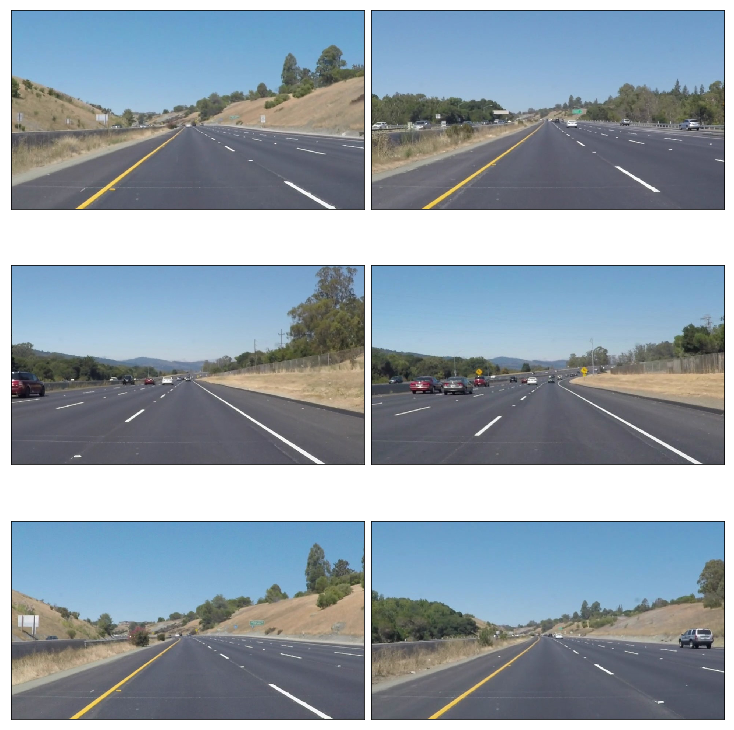

In [178]:
test_image_paths  =  [path for path in glob.glob('test_images/*.jpg')]
test_images       =  [plt.imread(path) for path in test_image_paths]
show_images(test_images)

## Build a Lane Detection Pipeline

### 1. Step: Grayscaling
First the images are converted into grayscale images, because we don't need colors for edge detection and it's easier to handle graysacle images with only one dimension instead of color images with three dimensions.

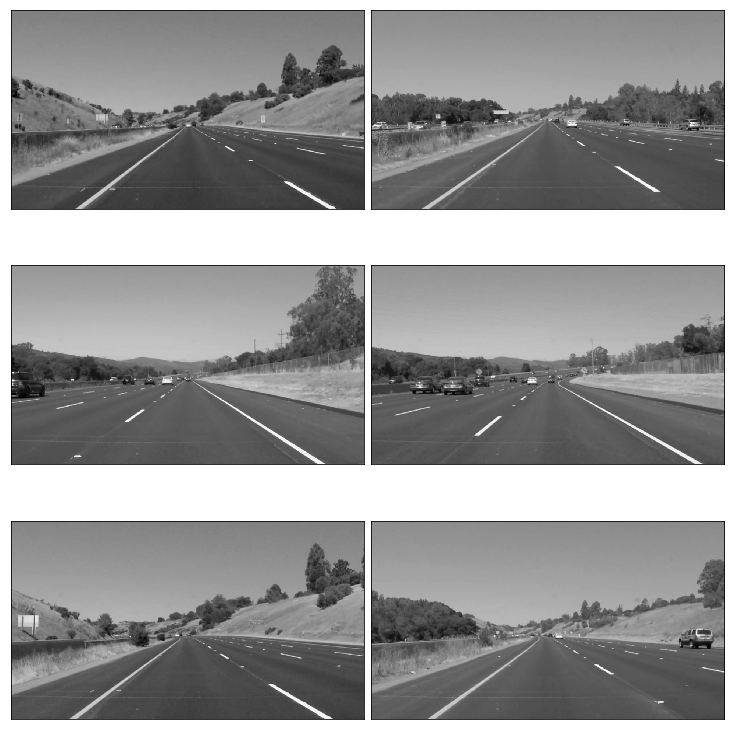

In [179]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, test_images))
show_images(gray_images)

### 2. Step: Gaussian Smooting
The kernal size of the Gaussian filter: The smoothing filter used in the first stage directly affects the results of the Canny algorithm. Smaller filters cause less blurring, and allow detection of small, sharp lines. A larger filter causes more blurring, smearing out the value of a given pixel over a larger area of the image. Larger blurring radii are more useful for detecting larger, smoother edges.

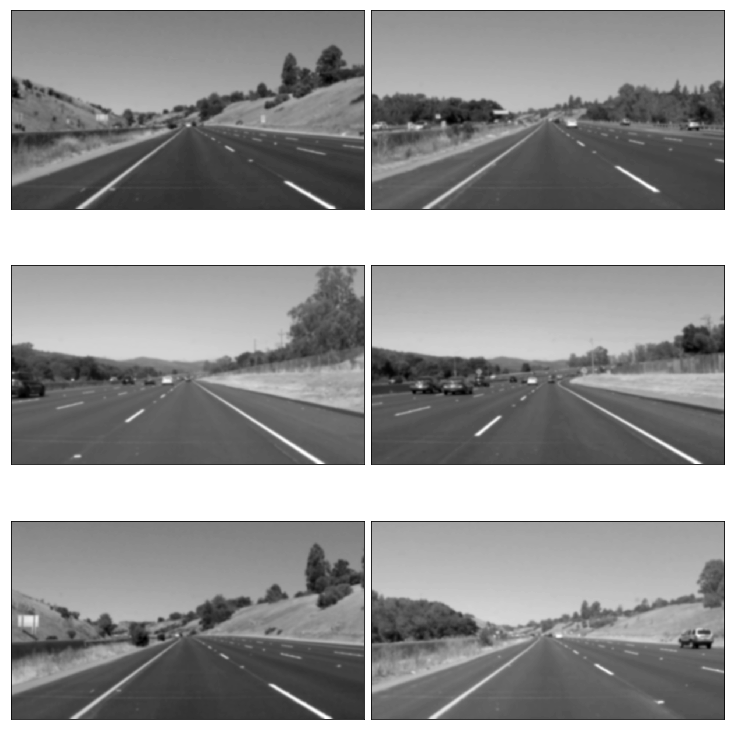

In [180]:
def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))
show_images(blurred_images)

### 3. Step: Canny Edge Detection
Next we use the Canny Edge Detection algorithm to detect edges in our test images.

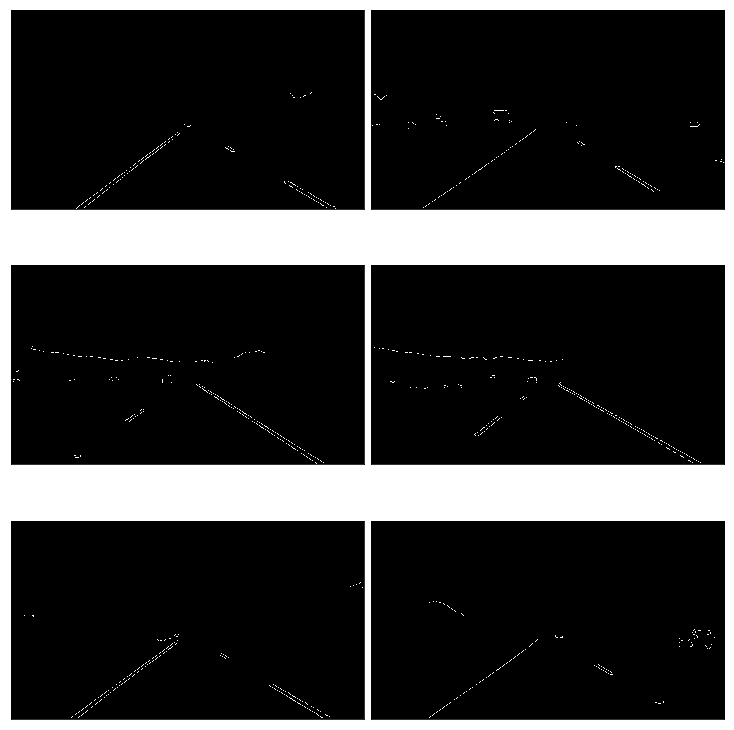

In [181]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))
show_images(edge_images)

### 4. Step: Region of Interest Filtering
Assuming that the camera is centered on the front of the car, the road we want to detect in the image is in a triangular area, from the points at the bottom left, to about the center of the image and bottom right. All other areas of the image are not of interest, and therefore we mask out them in black. 

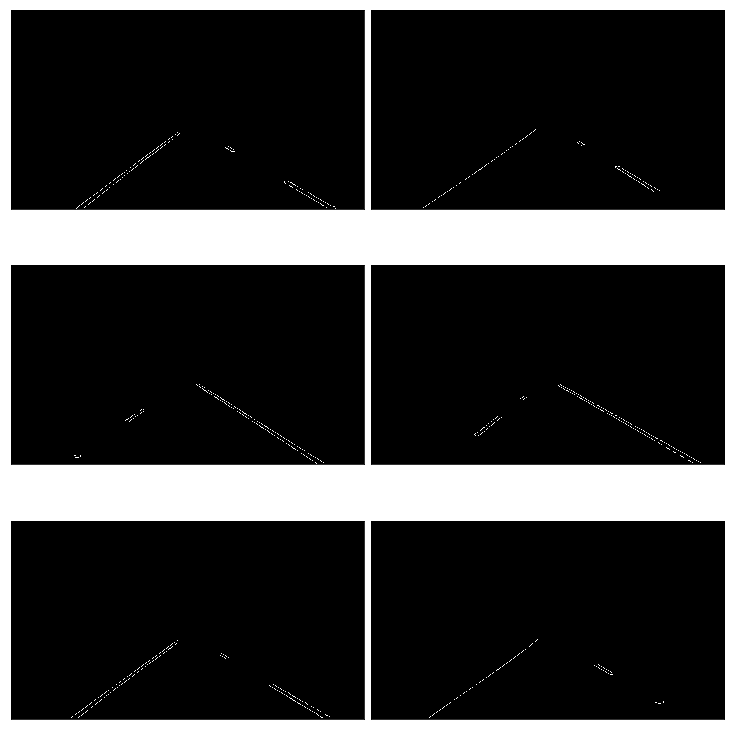

In [214]:
def region_of_interest(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,) * mask.shape[2])  # in case, the input image has a channel dimension
    return cv2.bitwise_and(image, mask)


# region of interest will be a centered trapezoid rising from the bottom of the image.
# These parameters tune the shape of the trapezoid.
roi_horiz_top = 0.45 # x-coord of trapezoid's top left point will be img.shape[1]*roi_horiz_top
                     # x-coord of trapezoid's top right point will be img.shape[1]*(1.-roi_horiz_top)
roi_horiz_bot = 0.05 # x-coord of trapezoid's bottom left point will be img.shape[1]*roi_horiz_bot
                     # x-coord of trapezoid's bottom right point will be img.shape[1]*)(1.-roi_horiz_bot)
roi_vert = 0.6       # y-coord of trapezoid's top will be imshape[1]*roi_vert_frac

# images showing the region of interest only
ymax = edge_images[0].shape[0]
xmax = edge_images[0].shape[1]
vertices = np.array([[(xmax*roi_horiz_top     , ymax*roi_vert),\
                      (xmax*roi_horiz_bot     , ymax         ),\
                      (xmax*(1.-roi_horiz_bot), ymax         ),\
                      (xmax*(1.-roi_horiz_top), ymax*roi_vert)]], dtype=np.int32)

def select_roi(edge_image):
    return region_of_interest(edge_image, vertices)

roi_images = list(map(select_roi, edge_images))
show_images(roi_images)

### 5. Step: Hough Transform Line Detection
The Canny Edge Detection returned many edges, but we want lines. Hough Line Transform helps us to transform the edges into lines.

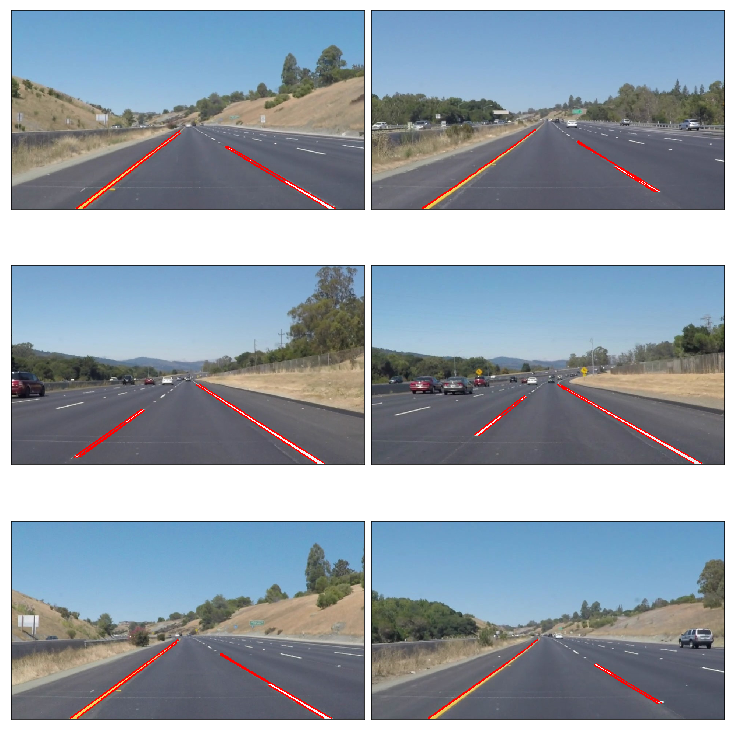

In [215]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi / 180, threshold=20, minLineLength=20, maxLineGap=300)

def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    image = np.copy(image)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

list_of_lines = list(map(hough_lines, roi_images))
line_images = []

for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))

show_images(line_images)

### 6. Step: Calculate Lane Lines
The Hough Line Transformation returned many lines with different slope, intercept and length. But we want to detect only two line lanes, the right and the left one. The idea is to first split all lines into rigtht lines and left lines by their slope. Then we can build the average of the right and left lines, the two averages corresponds to the right and left lane line. Finally we extrapolate the detected line lanes from the bottom of the image to the top of the region of interest, to get two line lanes with equal length.

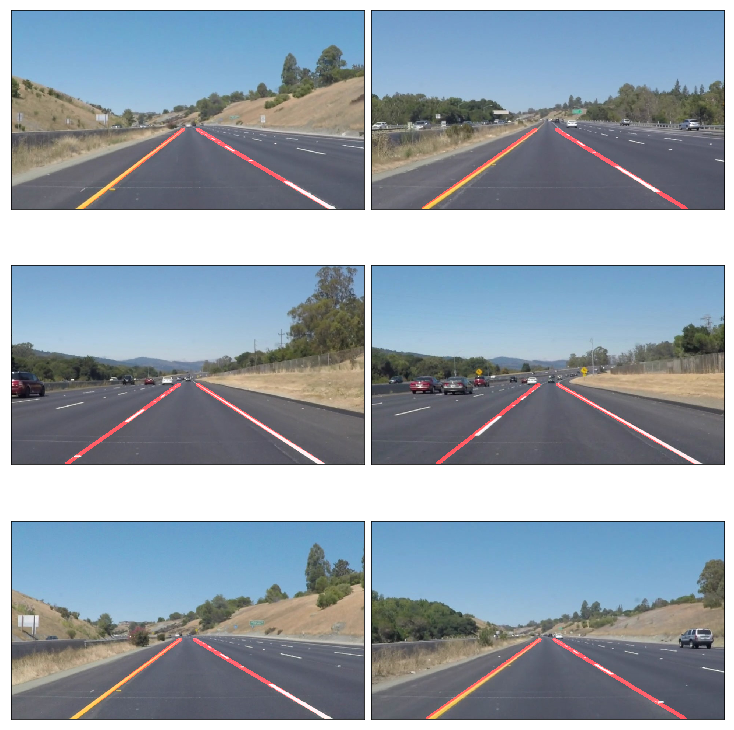

In [218]:
def draw_lines(image, lines, roi_vert, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    rslope = []
    lslope = []
    rcenterx = []
    rcentery = []
    lcenterx = []
    lcentery = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            centerx = (x1 + x2) / 2
            centery = (y1 + y2) / 2

            if slope > 0.5:
                if slope < 0.8:
                    rslope.append(slope)
                    rcenterx.append(centerx)
                    rcentery.append(centery)

            elif slope < -0.5:
                if slope > -0.8:
                    lslope.append(slope)
                    lcenterx.append(centerx)
                    lcentery.append(centery)

    rslope_avg = np.sum(rslope) / len(rslope)
    lslope_avg = np.sum(lslope) / len(lslope)

    rcenterx_avg = np.sum(rcenterx) / len(rcenterx)
    rcentery_avg = np.sum(rcentery) / len(rcentery)
    lcenterx_avg = np.sum(lcenterx) / len(lcenterx)
    lcentery_avg = np.sum(lcentery) / len(lcentery)

    ymax = math.floor(image.shape[0]*roi_vert)
    ymin = image.shape[0]-1

    xmax_left = int(lcenterx_avg - ((lcentery_avg - ymax) / lslope_avg))
    xmin_left = int(lcenterx_avg - ((lcentery_avg - ymin) / lslope_avg))

    xmax_right = int(rcenterx_avg - ((rcentery_avg - ymax) / rslope_avg))
    xmin_right = int(rcenterx_avg - ((rcentery_avg - ymin) / rslope_avg))

    cv2.line(image, (xmax_right, ymax), (xmin_right, ymin), color, thickness)
    cv2.line(image, (xmax_left, ymax), (xmin_left, ymin), color, thickness)


def weighted_img(img, initial_img):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, 1.0, img, 0.95, 0.0)


def combine_images(image, line_image):
    return weighted_img(line_image, image)


def draw_hough_lines(image, roi_vert):
    """
    `image` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi / 180, threshold=20, minLineLength=20, maxLineGap=300)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, roi_vert)
    return line_img

def draw_hough_line(image):
    return draw_hough_lines(image, roi_vert)

hough_lines = list(map(draw_hough_line, roi_images))

lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_images.append(combine_images(image, lines))
    
show_images(lane_images)


### 7. Step: Save output images
Finally we save the image copies with the lane line annotations in the `test_images_output` directory.

In [219]:
def save_image(image, filename):
    cv2.imwrite(os.path.join('test_images_output', filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR));

for image, path in zip(test_images, test_image_paths):
    save_image(image, os.path.basename(path))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [222]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    ymax = image.shape[0]
    xmax = image.shape[1]
    vertices = np.array([[(xmax*roi_horiz_top     , ymax*roi_vert),\
                          (xmax*roi_horiz_bot     , ymax         ),\
                          (xmax*(1.-roi_horiz_bot), ymax         ),\
                          (xmax*(1.-roi_horiz_top), ymax*roi_vert)]], dtype=np.int32)

    # lane line detection pipeline
    gray = convert_gray_scale(image)
    smooth_gray = apply_smoothing(gray)
    edges = detect_edges(smooth_gray)
    roi = region_of_interest(edges, vertices)
    hough = draw_hough_lines(roi, roi_vert)
    output_image = combine_images(image, hough)
    return output_image

def process_video(video_input, video_output):
    clip = VideoFileClip(video_input)
    processed = clip.fl_image(process_image)
    processed.write_videofile(video_output, audio=False)

Let's try image `solidWhiteRight.mp4` with the solid white lane on the right first ...

In [223]:
def get_input_path(path):
    return os.path.join('test_videos', path)

def get_output_path(path):
    return os.path.join('test_videos_output', path)

white_output = get_output_path('solidWhiteRight.mp4')
process_video(get_input_path('solidWhiteRight.mp4'), white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4











  0%|          | 0/222 [00:00<?, ?it/s]








  1%|▏         | 3/222 [00:00<00:07, 27.39it/s]








  3%|▎         | 7/222 [00:00<00:07, 28.44it/s]








  5%|▍         | 11/222 [00:00<00:07, 29.07it/s]








  7%|▋         | 15/222 [00:00<00:06, 29.69it/s]








  9%|▊         | 19/222 [00:00<00:06, 30.34it/s]








 10%|█         | 23/222 [00:00<00:06, 30.69it/s]








 12%|█▏        | 27/222 [00:00<00:06, 30.74it/s]








 14%|█▍        | 31/222 [00:01<00:06, 30.89it/s]








 16%|█▌        | 35/222 [00:01<00:06, 31.00it/s]








 18%|█▊        | 39/222 [00:01<00:05, 30.79it/s]








 19%|█▉        | 43/222 [00:01<00:07, 22.49it/s]








 21%|██        | 46/222 [00:01<00:09, 18.25it/s]








 22%|██▏       | 49/222 [00:02<00:10, 16.35it/s]








 23%|██▎       | 51/222 [00:02<00:11, 15.30it/s]








 24%|██▍       | 53/222 [00:02<00:11, 14.56it/s]








 25%|██▍       | 55/222 [00:02<00:11, 14.00it/s]








 26%|██▌       | 57/222 [00:02<00

ValueError: cannot convert float NaN to integer

Result for `solidWhiteRight.mp4`

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the `solidYellowLeft.mp4` with the solid yellow lane on the left.

In [224]:
yellow_output = get_output_path('solidYellowLeft.mp4')
process_video(get_input_path('solidYellowLeft.mp4'), yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4












  0%|          | 0/682 [00:00<?, ?it/s]









  0%|          | 3/682 [00:00<00:26, 25.58it/s]









  1%|          | 7/682 [00:00<00:24, 27.05it/s]









  2%|▏         | 11/682 [00:00<00:24, 27.95it/s]









  2%|▏         | 15/682 [00:00<00:23, 28.91it/s]









  3%|▎         | 18/682 [00:00<00:23, 28.84it/s]









  3%|▎         | 21/682 [00:00<00:22, 28.81it/s]









  4%|▎         | 24/682 [00:00<00:23, 28.52it/s]









  4%|▍         | 28/682 [00:00<00:22, 29.29it/s]









  5%|▍         | 32/682 [00:01<00:21, 29.85it/s]









  5%|▌         | 36/682 [00:01<00:21, 30.54it/s]









  6%|▌         | 39/682 [00:01<00:21, 30.14it/s]









  6%|▌         | 42/682 [00:01<00:21, 29.88it/s]









  7%|▋         | 45/682 [00:01<00:37, 16.97it/s]









  7%|▋         | 48/682 [00:01<00:41, 15.37it/s]









  7%|▋         | 51/682 [00:02<00:44, 14.29it/s]








 96%|█████████▌| 213/222 [00:30<00:01,  7.06it/s]









  8%|▊         

 30%|██▉       | 203/682 [00:14<00:38, 12.30it/s]









 30%|███       | 205/682 [00:14<00:38, 12.29it/s]









 30%|███       | 207/682 [00:14<00:38, 12.42it/s]









 31%|███       | 209/682 [00:15<00:37, 12.77it/s]









 31%|███       | 211/682 [00:15<00:37, 12.53it/s]









 31%|███       | 213/682 [00:15<00:37, 12.67it/s]









 32%|███▏      | 215/682 [00:15<00:36, 12.95it/s]









 32%|███▏      | 217/682 [00:15<00:36, 12.61it/s]









 32%|███▏      | 219/682 [00:15<00:36, 12.84it/s]









 32%|███▏      | 221/682 [00:15<00:35, 12.90it/s]









 33%|███▎      | 223/682 [00:16<00:35, 12.79it/s]









 33%|███▎      | 225/682 [00:16<00:37, 12.21it/s]









 33%|███▎      | 227/682 [00:16<00:36, 12.51it/s]









 34%|███▎      | 229/682 [00:16<00:36, 12.49it/s]









 34%|███▍      | 231/682 [00:16<00:36, 12.52it/s]









 34%|███▍      | 233/682 [00:16<00:35, 12.61it/s]









 34%|███▍      | 235/682 [00:17<00:36, 12.28it/s]








 57%|█████▋    | 387/682 [00:29<00:22, 12.99it/s]









 57%|█████▋    | 389/682 [00:29<00:22, 12.79it/s]









 57%|█████▋    | 391/682 [00:29<00:23, 12.64it/s]









 58%|█████▊    | 393/682 [00:29<00:23, 12.54it/s]









 58%|█████▊    | 395/682 [00:29<00:22, 12.83it/s]









 58%|█████▊    | 397/682 [00:29<00:21, 12.99it/s]









 59%|█████▊    | 399/682 [00:30<00:22, 12.76it/s]









 59%|█████▉    | 401/682 [00:30<00:21, 12.81it/s]









 59%|█████▉    | 403/682 [00:30<00:21, 12.95it/s]









 59%|█████▉    | 405/682 [00:30<00:22, 12.58it/s]









 60%|█████▉    | 407/682 [00:30<00:21, 12.93it/s]









 60%|█████▉    | 409/682 [00:30<00:21, 12.98it/s]









 60%|██████    | 411/682 [00:30<00:20, 13.05it/s]









 61%|██████    | 413/682 [00:31<00:20, 13.06it/s]









 61%|██████    | 415/682 [00:31<00:20, 13.03it/s]









 61%|██████    | 417/682 [00:31<00:20, 13.06it/s]









 61%|██████▏   | 419/682 [00:31<00:20, 12.61it/s]








 84%|████████▎ | 571/682 [00:43<00:08, 12.35it/s]









 84%|████████▍ | 573/682 [00:43<00:08, 12.23it/s]









 84%|████████▍ | 575/682 [00:43<00:08, 12.32it/s]









 85%|████████▍ | 577/682 [00:44<00:08, 12.22it/s]









 85%|████████▍ | 579/682 [00:44<00:08, 12.45it/s]









 85%|████████▌ | 581/682 [00:44<00:08, 12.50it/s]









 85%|████████▌ | 583/682 [00:44<00:08, 11.53it/s]









 86%|████████▌ | 585/682 [00:44<00:08, 12.07it/s]









 86%|████████▌ | 587/682 [00:44<00:07, 12.21it/s]









 86%|████████▋ | 589/682 [00:45<00:07, 12.39it/s]









 87%|████████▋ | 591/682 [00:45<00:07, 12.50it/s]









 87%|████████▋ | 593/682 [00:45<00:07, 12.71it/s]









 87%|████████▋ | 595/682 [00:45<00:06, 12.83it/s]









 88%|████████▊ | 597/682 [00:45<00:06, 13.07it/s]









 88%|████████▊ | 599/682 [00:45<00:06, 13.08it/s]









 88%|████████▊ | 601/682 [00:45<00:06, 12.64it/s]









 88%|████████▊ | 603/682 [00:46<00:06, 12.82it/s]








[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 



Result for `solidYellowLeft.mp4`

In [225]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [226]:
challenge_output = get_output_path('challenge.mp4')
process_video(get_input_path('challenge.mp4'), challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4












  0%|          | 0/251 [00:00<?, ?it/s]









  1%|          | 2/251 [00:00<00:15, 16.43it/s]









  2%|▏         | 4/251 [00:00<00:14, 16.50it/s]









  2%|▏         | 6/251 [00:00<00:14, 16.39it/s]









  3%|▎         | 8/251 [00:00<00:14, 16.80it/s]









  4%|▍         | 10/251 [00:00<00:14, 16.93it/s]









  5%|▍         | 12/251 [00:00<00:14, 17.03it/s]









  6%|▌         | 14/251 [00:00<00:14, 16.92it/s]









  6%|▋         | 16/251 [00:00<00:13, 17.01it/s]









  7%|▋         | 18/251 [00:01<00:13, 17.08it/s]









  8%|▊         | 20/251 [00:01<00:13, 17.31it/s]









  9%|▉         | 22/251 [00:01<00:13, 17.11it/s]









 10%|▉         | 24/251 [00:01<00:13, 16.97it/s]









 10%|█         | 26/251 [00:01<00:13, 16.71it/s]









 11%|█         | 28/251 [00:01<00:13, 16.70it/s]









 12%|█▏        | 30/251 [00:01<00:13, 16.20it/s]









 13%|█▎        | 32/251 [00:01<00:13, 16.50it/s]









 14%|█▎        | 

ValueError: cannot convert float NaN to integer

Result for `challenge.mp4`

In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))